In [215]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.metrics import SCORERS
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
load_dotenv()
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [119]:
from pymongo import MongoClient
import numpy as np

MONGO_PASSWORD = os.environ['MONGO_USER_PASSWORD']
CROWD_TANGLE = os.environ['CROWD_TANGLE_API_TOKEN']

config = {
  'host': '18.216.52.13:27017',
  'username': 'mongo_user',
  'password': MONGO_PASSWORD,
  'authSource': 'reddit_climate_news'
}

db = MongoClient(**config).reddit_climate_news

# Plan

Model: Random Forest

Features:
    - hour bucket
    - day of week categorical
    - tone score
    - sentiment
    - facebook comments
    - length of article
    
Dep Var:
    - Number of comments
    - score

In [120]:
res = db.climate_submissions.aggregate([
    { '$project': {
        'score': 1,
        'num_comments': 1,
        'url': 1,
        'text': '$text_razor.results.cleanedText',
        'created_utc': 1,
        'sentiment_score': 1,
        'tones': '$tone_analyzer.document_tone.tones',
        'fb_interactions': '$crowd_tangle.result.interactions',
        'num_images': { '$cond': { 'if': { '$isArray': "$preview.images" }, 'then': { '$size': "$preview.images" }, 'else': 0} }
    }}])

In [121]:
df = pd.DataFrame.from_records([{**x, **x.get('fb_interactions', {})} for x in res])

# Data Prepping

In [198]:
df['post_date'] = df.created_utc.map(datetime.fromtimestamp)
df['hour_bucket'] = df.post_date.map(lambda x: x.hour // 4)
df['day_of_week'] = df.post_date.map(lambda x: x.weekday())

In [199]:
def extract_score_from_tones(tones, tone_id):
    """
    Extracts specific tone score from array of tone values

    Args:
        tones (list): List of tone objects from IBM tone API
        tone_id (str): specific tone id

    Returns:
        Score as float if it exists. NaN if not.
    """
    matching_tones = [t for t in tones if t['tone_id'] == tone_id]

    if not matching_tones:
        return np.nan

    return matching_tones[0]['score']

def extract_score(raw_tone, tone_id):
    """
    Extracts specific tone score from raw tone API response

    Args:
        raw_tone (obj): Raw response object from IBM tone API
        tone_id (str): specific tone id

    Returns:
        Score as float if it exists. NaN if not.
    """
    if not raw_tone.get('document_tone'):
        return np.nan

    tones = raw_tone.get('document_tone').get('tones')
    return extract_score_from_tones(tones, tone_id)

In [200]:
for t in ['analytical', 'anger', 'confident', 'fear', 'joy', 'sadness', 'tentative']:
    df[t] = df.tones.map(lambda ta: extract_score_from_tones(ta, t))

In [205]:
dummied = pd.get_dummies(df, columns=['hour_bucket', 'day_of_week'])

In [202]:
# dummied = df.copy()

In [206]:
baseline_df = dummied.drop(columns=['_id', 'created_utc', 'url', 'tones', 'fb_interactions', 'post_date'])
baseline_df = baseline_df.dropna(subset=[
    'facebookInteractionCount',
    'reactionCount',
    'reactionCount',
    'reactionCount'
])
baseline_df = baseline_df.fillna(0)

# EDA

In [211]:
sns.pairplot(baseline_df, hue='viral')

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x2f308495f0> (for post_execute):


KeyboardInterrupt: 

In [212]:
baseline_df.viral.value_counts()

0    2093
1      57
Name: viral, dtype: int64

# Baseline Model

In [213]:
X, y = baseline_df[[
    'reactionCount',
    'facebookInteractionCount',
    'commentCount',
    'shareCount',
    'sentiment_score',
    'sadness',
    'num_images',
    'analytical',
]], baseline_df.viral
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

In [220]:
cv_res = cross_validate(
    RandomForestClassifier(
        random_state=42,
        max_depth=5,
        n_estimators=100
    ),
    X_train,
    y_train,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
#     scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
    scoring=['precision', 'recall'],
    return_train_score=True,
    return_estimator=True
)

/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pre

In [221]:
cv_res

{'fit_time': array([0.18975496, 0.21356273, 0.26367807, 0.27419329, 0.22830796]),
 'score_time': array([0.03785706, 0.06116509, 0.03751183, 0.03212094, 0.04099393]),
 'estimator': (RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                         max_depth=5, max_features='auto', max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=100,
                         n_jobs=None, oob_score=False, random_state=42, verbose=0,
                         warm_start=False),
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                         max_depth=5, max_features='auto', max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                   

In [195]:
for f in cv_res['estimator']:
    print('******')
    for n, i in sorted(zip(X.columns, f.feature_importances_), key=lambda x: x[1]):
        print(n, ' - ', i)

******
analytical  -  0.03750048533731749
reactionCount  -  0.05987862332637816
num_images  -  0.07499549117798864
facebookInteractionCount  -  0.07851375050456964
sadness  -  0.08508186748145034
shareCount  -  0.17099328082550225
commentCount  -  0.18765789116703338
sentiment_score  -  0.30537861017976015
******
sadness  -  0.021096239315068953
num_images  -  0.03148109431956674
analytical  -  0.06099792024722622
facebookInteractionCount  -  0.1239944229887875
reactionCount  -  0.1340101836887564
commentCount  -  0.14251328196468946
shareCount  -  0.2266165668030121
sentiment_score  -  0.25929029067289266
******
num_images  -  0.0741359079483466
analytical  -  0.08402087814393781
shareCount  -  0.10719916064838327
reactionCount  -  0.12052408570577677
sadness  -  0.12850671513452006
sentiment_score  -  0.14269161851103207
facebookInteractionCount  -  0.1490497123622998
commentCount  -  0.1938719215457036
******
num_images  -  0.027582235939675775
facebookInteractionCount  -  0.0535172

In [175]:
y.describe()

count    2150.000000
mean       86.292558
std       415.981574
min         0.000000
25%         1.000000
50%         4.000000
75%        16.000000
max      6466.000000
Name: num_comments, dtype: float64

In [183]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.8, random_state=42)
rf_plot = RandomForestRegressor(
    random_state=42,
    max_depth=3,
    n_estimators=100
)
rf_plot.fit(X_tr, y_tr)
preds = rf_plot.predict(X_tr)
preds_oos = rf_plot.predict(X_val)

Text(0.5, 1.0, 'In Sample')

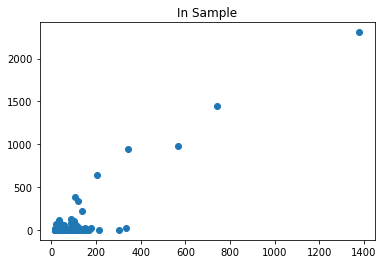

In [184]:
plt.scatter(preds, y_tr)
plt.title('In Sample')

Text(0.5, 1.0, 'Out of Sample')

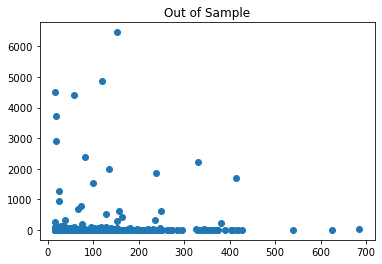

In [185]:
plt.scatter(preds_oos, y_val)
plt.title('Out of Sample')